In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Color quantization using K-means

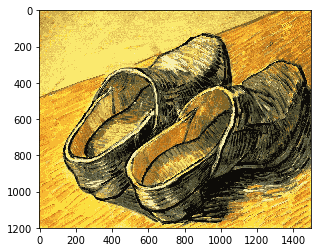

In [11]:
# https://docs.opencv.org/3.1.0/d1/d5c/tutorial_py_kmeans_opencv.html

img = cv2.imread('data/a-pair-of-leather-clogs-1888.jpg', cv2.COLOR_BGR2RGB)
Z = img.reshape((-1, 3))
Z = np.float32(Z)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 20
ret,label,center=cv2.kmeans(Z, K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Now convert back into uint8, and make original image
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))
res2 = cv2.cvtColor(res2, cv2.COLOR_BGR2RGB)

plt.imshow(res2)
plt.show()

## Cluster colors

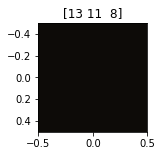

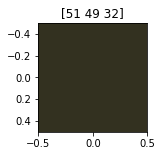

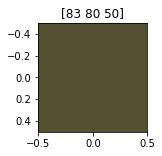

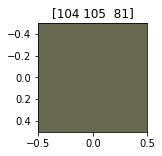

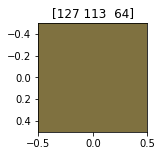

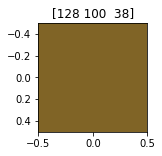

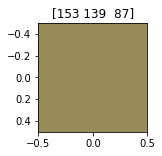

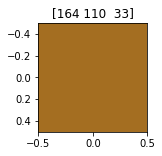

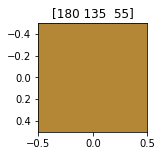

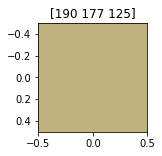

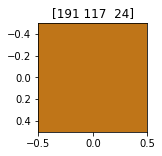

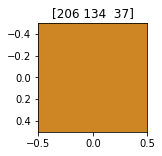

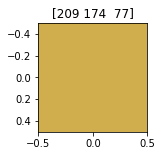

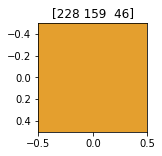

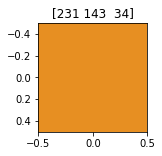

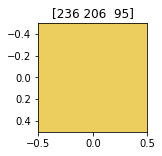

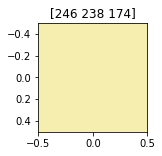

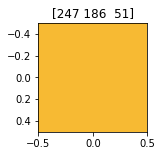

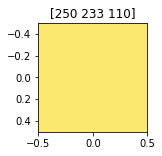

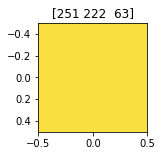

In [12]:
color_clusters = np.unique(res2.reshape(-1, img.shape[2]), axis=0)

for c in color_clusters:
    a = np.full((1, 1, 3), c)
    plt.figure(figsize=(2,2))
    plt.imshow(a)
    plt.title(c)
    plt.show()

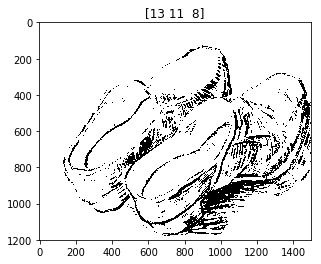

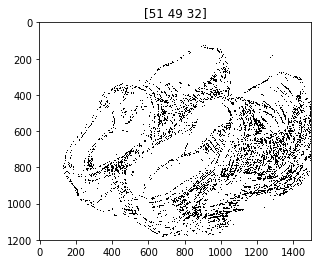

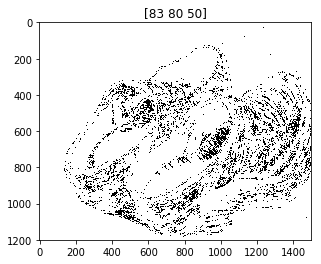

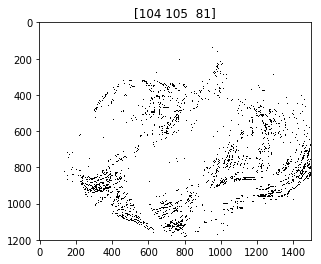

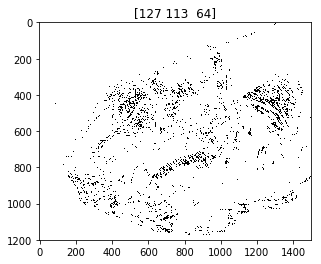

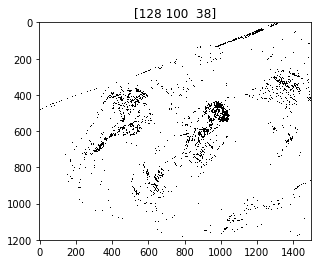

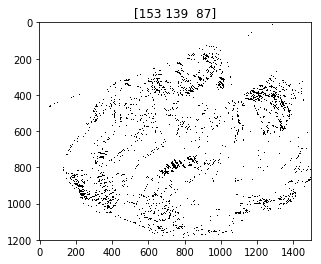

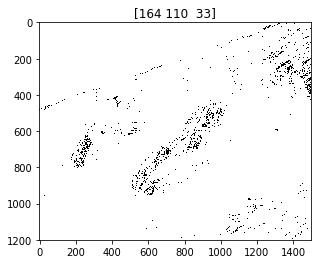

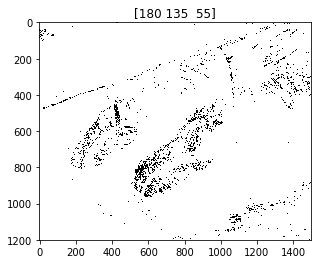

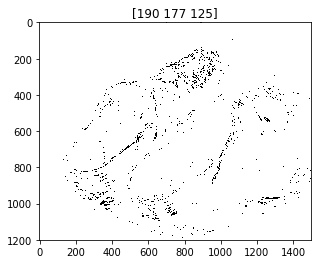

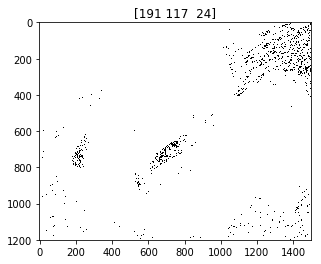

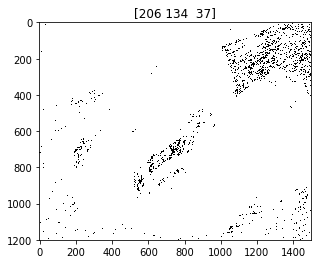

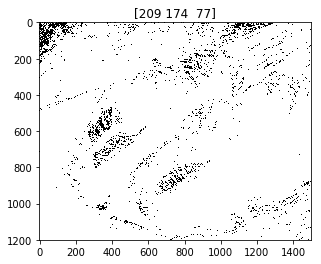

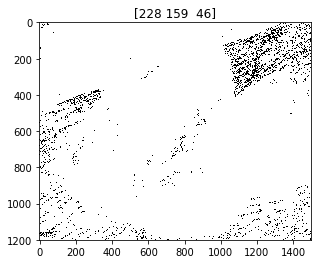

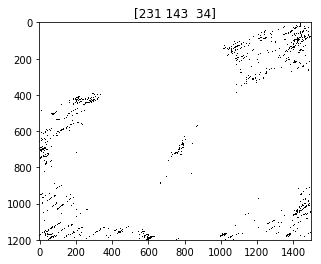

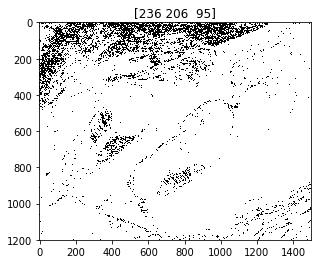

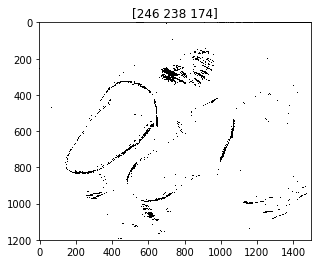

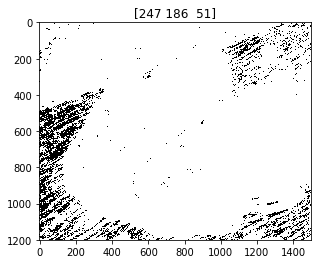

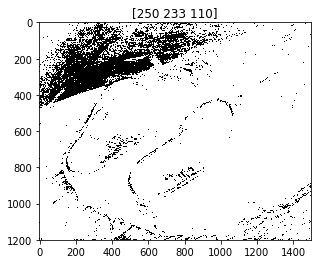

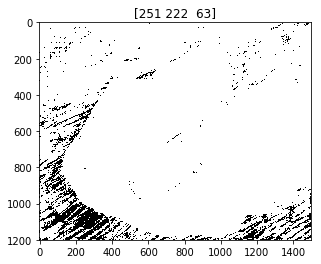

In [165]:
for c in color_clusters:
    ans = np.where(res2 == c, 0, 255)
    ans = ans[:,:,0]
    ans = np.uint8(ans / 255)
    plt.imshow(ans, 'gray')
    plt.title(c)
    plt.show()

## Closing

In [166]:
np.where(color_clusters == (246,238,174))

(array([16, 16, 16]), array([0, 1, 2]))

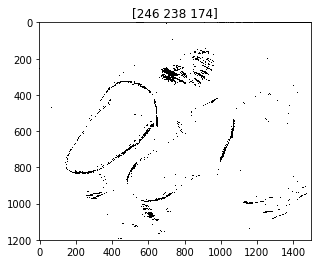

In [167]:
c = color_clusters[16]
binaria = np.where(res2 == c, 0, 255)
binaria = binaria[:,:,0]
binaria = np.uint8(binaria / 255)
plt.imshow(binaria, 'gray')
plt.title(c)
plt.show()

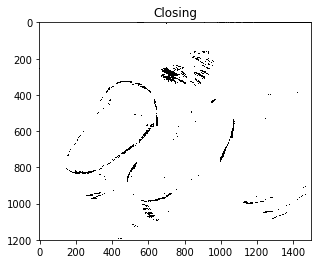

In [170]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3, 3))
binaria_closing = cv2.morphologyEx(binaria, cv2.MORPH_CLOSE, kernel);
plt.imshow(binaria_closing,'gray'); plt.title('Closing'); plt.show()

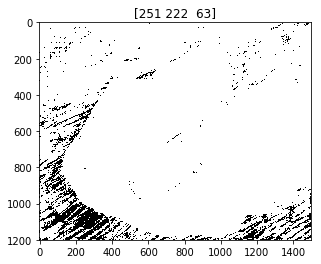

In [177]:
c = color_clusters[-1]
binaria2 = np.where(res2 == c, 0, 255)
binaria2 = binaria2[:,:,0]
binaria2 = np.uint8(binaria2 / 255)
plt.imshow(binaria2, 'gray')
plt.title(c)
plt.show()

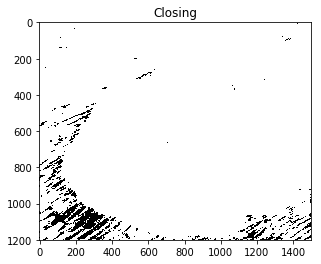

In [181]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5, 5))
binaria_closing2 = cv2.morphologyEx(binaria2, cv2.MORPH_CLOSE, kernel);
plt.imshow(binaria_closing2,'gray'); plt.title('Closing'); plt.show()

## Thinning

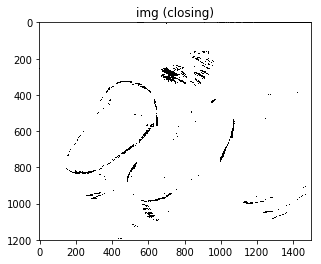

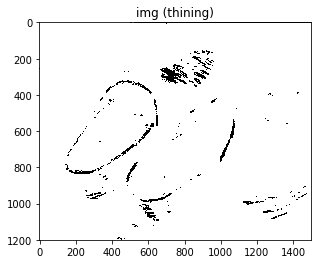

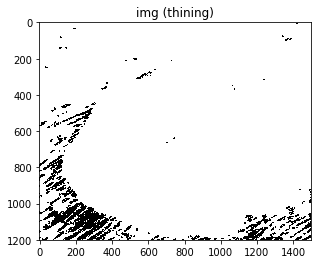

In [183]:
def thinning(img, niter=8, verbose=False):
    k = np.array([[[-1,-1,-1],[0,1,0],[1,1,1]], # kernels do slide 45
                  [[0,-1,-1],[1,1,-1],[1,1,0]], # -1 background, 1 foreground, 0 ignorado.
                  [[1,0,-1],[1,1,-1],[1,0,-1]],
                  [[1,1,0],[1,1,-1],[0,-1,-1]],
                  [[1,1,1],[0,1,0],[-1,-1,-1]],
                  [[0,1,1],[-1,1,1],[-1,-1,0]],
                  [[-1,0,1],[-1,1,1],[-1,0,1]],
                  [[-1,-1,0],[-1,1,1],[0,1,1]]])        
    for i in range(niter):
        m = cv2.morphologyEx(img, cv2.MORPH_HITMISS, k[i % 8])
        img = img * (1 - m) # thinning = img inter (complemento do hit-and-miss)
        if verbose:
            plt.imshow(k[i % 8],'gray'); plt.show()
            plt.imshow(img,'gray'); plt.show()
    return img

plt.imshow(binaria_closing, 'gray'); plt.title('img (closing)'); plt.show()
img_thinning = thinning(binaria_closing, 16, False)
img_thinning2 = thinning(binaria_closing2, 16, False)
plt.imshow(img_thinning, 'gray'); plt.title('img (thining)'); plt.show()
plt.imshow(img_thinning2, 'gray'); plt.title('img (thining)'); plt.show()

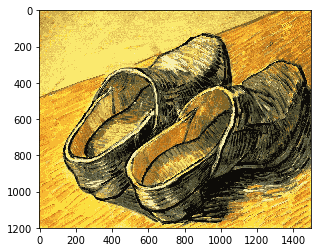

In [172]:
plt.imshow(res2)

In [185]:
img_rgb = cv2.cvtColor(img_thinning, cv2.COLOR_GRAY2RGB)
img_rgb = np.uint8(img_rgb * 255)

img_rgb2 = cv2.cvtColor(img_thinning2, cv2.COLOR_GRAY2RGB)
img_rgb2 = np.uint8(img_rgb2 * 255)
# mask = np.all(img_rgb == (255, 255, 255), axis=-1)

In [203]:
ans_c0 = np.where(img_rgb == (255,255,255), (0,0,0), res2)
ans_c1 = np.where(img_rgb2 == (255,255,255), (0,0,0), res2)

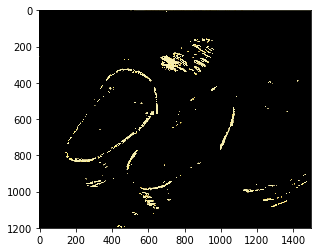

In [204]:
plt.imshow(ans_c0)

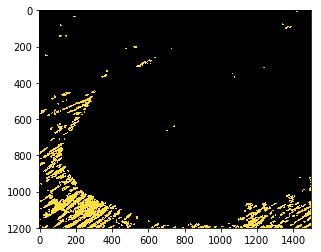

In [205]:
plt.imshow(ans_c1)

In [210]:
ans = cv2.add(ans_c0,ans_c1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


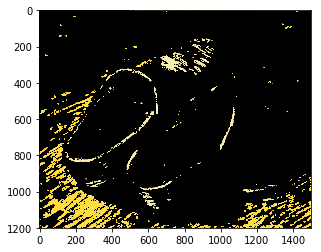

In [208]:
plt.imshow(ans)